In [1]:
import numpy as np
import anndata
import pandas as pd
import scanpy as sc
import scipy
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sys,os
sys.path.append('/home/mgander/mouse_atlas')
import c2

In [3]:
Path="/home/mgander/mouse_atlas/data"
#Path="/home/icb/manuel.gander/mouse_atlas/data"
ts=['E3.5', 'E4.5', 'E5.25', 'E5.5', 'E6.25', 'E6.5', 'E6.75', 'E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5a', 'E8.5b', 'E9.5', 'E10.5', 'E11.5', 'E12.5', 'E13.5']

In [4]:
D_stage={}

pregast=['E3.5', 'E4.5', 'E5.25', 'E5.5', 'E6.25']
gast=['E6.5', 'E6.75', 'E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25']
organ=['E8.5a', 'E8.5b', 'E9.5', 'E10.5', 'E11.5', 'E12.5']

D_stage=D_stage|{pregast[i]:'Pregastrulation' for i in range(len(pregast))}
D_stage=D_stage|{gast[i]:'Gastrulation' for i in range(len(gast))}
D_stage=D_stage|{organ[i]:'Organogenesis' for i in range(len(organ))}

In [5]:
cutoff=0.05

In [6]:
# Germ layer

In [7]:
frames=[]
for i in range(19):
    ts0=ts[i]
    ts1=ts[i+1]
    print(f'{ts0}_{ts1}')
    CT0=pd.read_pickle(f'{Path}/moscot_maps/Anchors/CTs/{ts0}_{ts1}_cell_type_transitions.pkl')
    CT1=pd.read_csv(f'{Path}/TOME_maps/Anchors/TOME_map_{ts0}_{ts1}.csv')
    CT1.index=list(CT1['Unnamed: 0'])
    del CT1['Unnamed: 0']
    CT1=CT1.T.copy()
    
    
    df0=c2.evaluate_using_germ_layers(CT0, cutoff)
    df0['Method']='moscot'
    df1=c2.evaluate_using_germ_layers(CT1, cutoff)
    df1['Method']='TOME'
    dfc=pd.concat([df0,df1], ignore_index=True)
    dfc['timepair']=ts0+'_'+ts1
    dfc['Number_of_cell_types']=CT0.shape[0]
    dfc['Stage']=D_stage[ts0]
    
    frames.append(dfc)
dfg=pd.concat(frames, ignore_index=True)

E3.5_E4.5
E4.5_E5.25
E5.25_E5.5
E5.5_E6.25
E6.25_E6.5


In [33]:
# Curated

In [34]:
frames=[]
for i in range(19):
    ts0=ts[i]
    ts1=ts[i+1]
    print(f'{ts0}_{ts1}')
    CT0=pd.read_pickle(f'{Path}/moscot_maps/Anchors/CTs/{ts0}_{ts1}_cell_type_transitions.pkl')
    CT1=pd.read_csv(f'{Path}/TOME_maps/Anchors/TOME_map_{ts0}_{ts1}.csv')
    CT1.index=list(CT1['Unnamed: 0'])
    del CT1['Unnamed: 0']
    CT1=CT1.T.copy()
    
    
    df0=c2.evaluate_using_curated_transitions(CT0, cutoff)
    df0['Method']='moscot'
    df1=c2.evaluate_using_curated_transitions(CT1, cutoff)
    df1['Method']='TOME'
    dfc=pd.concat([df0,df1], ignore_index=True)
    dfc['timepair']=ts0+'_'+ts1
    dfc['Number_of_cell_types']=CT0.shape[0]
    dfc['Stage']=D_stage[ts0]

    frames.append(dfc)
dfc=pd.concat(frames, ignore_index=True)

E3.5_E4.5
E4.5_E5.25
E5.25_E5.5
E5.5_E6.25
E6.25_E6.5
E6.5_E6.75
E6.75_E7.0
E7.0_E7.25
E7.25_E7.5
E7.5_E7.75
E7.75_E8.0
E8.0_E8.25
E8.25_E8.5a
E8.5a_E8.5b
E8.5b_E9.5
E9.5_E10.5
E10.5_E11.5
E11.5_E12.5
E12.5_E13.5


# Evaluate cell type transitions

In [55]:
def get_averaged_accuarcy(Df):
    ss=[]
    rs=[]
    ac=[]
    for s in ['Pregastrulation', 'Gastrulation', 'Organogenesis']:
        for r in ['moscot', 'TOME']:
            ss.append(s)
            rs.append(r)
            dfs=Df[(Df['Method']==r)&(Df['Stage']==s)]
            ac.append(np.average(dfs['Accuracy'], weights=dfs['Number_of_cell_types']))
    Dfc=pd.DataFrame({'Method':rs, 'Stage':ss, 'Weighted_accuracy':ac})
    return Dfc

In [56]:
Dfg=get_averaged_accuarcy(dfg)
Dfc=get_averaged_accuarcy(dfc)

In [57]:
import mplscience
mplscience.set_style(reset_current=True)

pal=sns.color_palette()
paln=pal.copy()
paln[0]=np.array([13,111,178])/255

In [58]:
D_stage_names0={'Pregastrulation':'Pre-Gastrulation\n (E3.5 to E6.5) ', 'Gastrulation':'Gastrulation   \n(E6.5 to E8.5)  ',
               'Organogenesis':'Organogenesis \n(E8.5 to E13.5) '}
D_stage_names1={'Pregastrulation':'Pre-Gastrulation', 'Gastrulation':'Gastrulation   ',
               'Organogenesis':'Organogenesis '}

Dfg['Stage1']=[D_stage_names0[a] for a in Dfg['Stage']]
Dfc['Stage1']=[D_stage_names1[a] for a in Dfc['Stage']]

/tmp/ipykernel_31720/3217874114.py:5: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g0=sns.barplot(ax=axs[0], data=Dfg, x='Weighted_accuracy', y="Stage1", hue='Method', palette=paln,
/home/mgander/miniconda3/envs/phos/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/mgander/miniconda3/envs/phos/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/tmp/ipykernel_31720/3217874114.py:14: UserWarning: The palette list has more values (10) than needed (2),

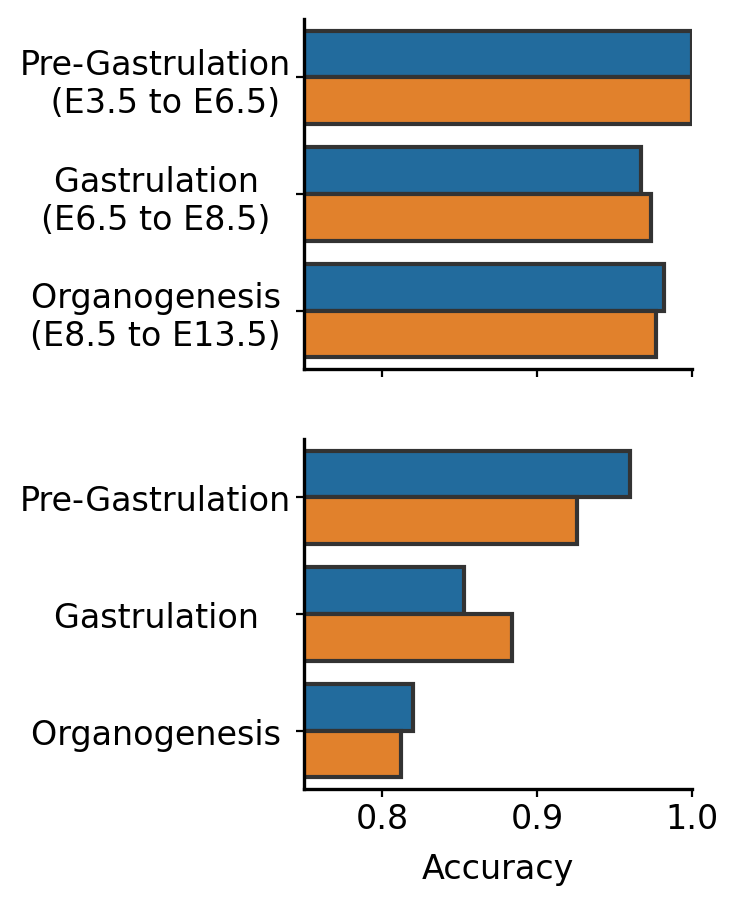

In [60]:
xlim=0.75

fig, axs = plt.subplots(2, 1, figsize=(2.5, 5), dpi=200)
# Germ layer transitions
g0=sns.barplot(ax=axs[0], data=Dfg, x='Weighted_accuracy', y="Stage1", hue='Method', palette=paln,
               linewidth=1.5, edgecolor='0.2')

g0.set(xticklabels=[])
g0.set(xlabel=None)
g0.set(ylabel=None)  

# Curated transitions

g1=sns.barplot(ax=axs[1], data=Dfc, x='Weighted_accuracy', y="Stage1", hue='Method', palette=paln,
               linewidth=1.5, edgecolor='0.2')
g1.set(ylabel=None)
plt.xlabel('Accuracy', fontsize=12)
axs[0].legend_.remove()
axs[1].legend_.remove()
axs[0].set_xlim(xlim, 1)
axs[1].set_xlim(xlim, 1)


plt.show()